In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import datetime
import numpy
import math
import seaborn as sns
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

#The two truck data set paths are set here.
truck1csv = "../data/trucks/truck1.csv"
truck2csv = "../data/trucks/truck2.csv"

#The two column header dictonary paths are set here.
truck1dictcsv = "../data/dictionary/truck1dict.csv"
truck2dictcsv = "../data/dictionary/truck2dict.csv"

#Number of records desired from the data set.
numberOfRecords = 100

#If the number of values that are NOT Na type pass this percentage, the row will be deleted
rowNaNThresholdPercent = 75

#Create column conversion dictionaries from CSV files.
truck1dict={}
truck2dict={}
with open(truck1dictcsv, 'r') as f:
    for row in csv.reader(f):
        truck1dict.update({row[0]:row[1]})
        
with open(truck2dictcsv, 'r') as f:
    for row in csv.reader(f):
        truck2dict.update({row[0]:row[1]})


In [3]:
def readCsv(truck):
    return pd.read_csv(truck, header = [0])
    
def cullUtcCols(truckData):
    noUTC = truckData.drop(["UTC hour", "UTC minute", "UTC second", "UTC month", "UTC day", "UTC year"], axis = 1)
    return noUTC

"""Takes a DataFrame and a conversion dictionary as parameters;
    uses the dictionary to rename all matching columns then returns the changed DataFrame."""
def renameColumns(dataFrame, dictionary):
    return dataFrame.rename(columns = dictionary)

"""Finds threshold of Non-NA type using percentage and deletes rows."""
def removeUnnecessaryRows(dataFrame):
    length = len(dataFrame.columns)
    TValue = (rowNaNThresholdPercent / 100) * length
    print("Threshold value: " + str(int(TValue)))
    return dataFrame.dropna(thresh = int(TValue))

"""Finds columns with all Na types and deletes them."""
def removeUnnecessaryColumns(dataFrame):
    return dataFrame.dropna(axis=1, how='all')

# NOTE: The following function is unused in this notebook, but it can be used to convert CSV files into
# conversion dictionaries i.e. creating the column rename dictionaries, which was manually done in the
# previous block manually.

"""Creates a Python dictionary from a pre-defined CSV dictionary.
This will only look at the first two columns of the given CSV file."""
def createPythonDictionary(dictionaryCSV):
    # Initialize the resulting dictionary.
    dictResult = {}
    
    # Opens the passed in CSV which defines the rename dictionary and iterates through it to store each value into a Python dictionary.
    with open(dictionaryCSV, 'r') as f:
        for row in csv.reader(f):
            dictResult.update({row[0]:row[1]})
    return dictResult

In [4]:
truck1data = readCsv(truck1csv)
truck1data = cullUtcCols(truck1data)
truck1data = removeUnnecessaryRows(truck1data)
truck1data = renameColumns(truck1data, truck1dict)
truck1data = removeUnnecessaryColumns(truck1data)

truck2data = readCsv(truck2csv)
truck2data = cullUtcCols(truck2data)
truck2data = removeUnnecessaryRows(truck2data)
truck2data = renameColumns(truck2data, truck2dict)
truck2data = removeUnnecessaryColumns(truck2data)

Threshold value: 33
Threshold value: 30


In [5]:
def divideByDay(truck_df, byday_df=None):
    dates = []
    #truck_df = truck_df.head()
    for index, tdata in truck_df.iterrows():
        dates.append(tdata['Time (DateTime)'].split(' ')[0])
        #print(index, dates)
        
    truck_df['Time (DateTime)'] = dates
    
    if(byday_df):
        byday_df = truck_df.groupby('Time (DateTime)')[byday_df].mean()
    else:
        byday_df = truck_df.groupby('Time (DateTime)').mean()

    return byday_df

## Same use as divideByDay() but needs second parameter!! If no parameter given, error will be thrown.
def outlierDetection(truck_df, column_attribute):

    iterateData = 0
    fiveNum = [truck_df[column_attribute].quantile(0), truck_df[column_attribute].quantile(.25), truck_df[column_attribute].quantile(.5), truck_df[column_attribute].quantile(.75), truck_df[column_attribute].quantile(1)]
    iqr = fiveNum[3] - fiveNum[1]
    low_outl = fiveNum[1] - (1.5 * iqr)
    high_outl = fiveNum[3] + (1.5 * iqr)
    print("Before Outlier Deletion: " + str(fiveNum))
    print("Low bound: " + str(low_outl))
    print("High bound: " + str(high_outl))
 
    truck_df = truck_df[(truck_df[column_attribute] > low_outl)]
    truck_df = truck_df[(truck_df[column_attribute] < high_outl)]
    fiveNum = [truck_df[column_attribute].quantile(0), truck_df[column_attribute].quantile(.25), truck_df[column_attribute].quantile(.5), truck_df[column_attribute].quantile(.75), truck_df[column_attribute].quantile(1)]
    #iqr = fiveNum[3] - fiveNum[1]
    #low_outl = fiveNum[1] - (1.5 * iqr)
    #high_outl = fiveNum[3] + (1.5 * iqr)
    print("After Outlier Deletion: " + str(fiveNum))

    sns.boxplot(x=truck_df[column_attribute], showfliers=False)

    return truck_df

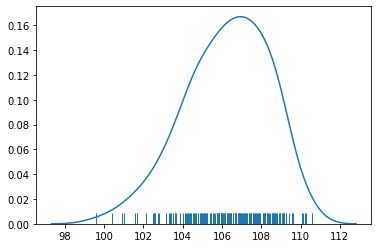

In [6]:
# Create empty list for point estimates.
truck1estimates = []
truck2estimates = []

# Runs through Oil Tempratures to get 200 samples, each of size 50.
for x in range(200):
    truck1estimates.append(truck1data['Oil Temperature (C)'].sample(n=50).mean())
    
for x in range(200):
    truck2estimates.append(truck2data['Oil Temperature (C)'].sample(n=50).mean())
    
ttest_ind(a = truck1estimates, b = truck2estimates, equal_var = False)

sns.distplot(truck1estimates, hist=False, rug=True); # Plot sample mean density


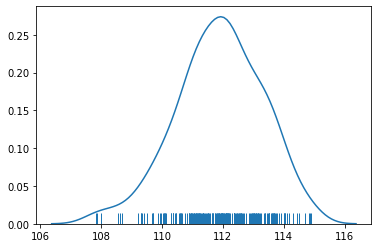

In [7]:
sns.distplot(truck2estimates, hist=False, rug=True); # Plot sample mean density
